In [1]:
#This file contains the code for Step 8.5: Reiteration.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('re').getOrCreate()

In [2]:
#Import essential libraries.
import nbimporter
import iteration4_1_du as du
import iteration4_2_dp_to_int as dm

import pandas as pd
import matplotlib.pyplot as plt 

from pyspark.sql.functions import col, when, countDistinct, avg, stddev, format_number
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor

Importing Jupyter notebook from iteration4_1_du.ipynb
Importing Jupyter notebook from iteration4_2_dp_to_int.ipynb


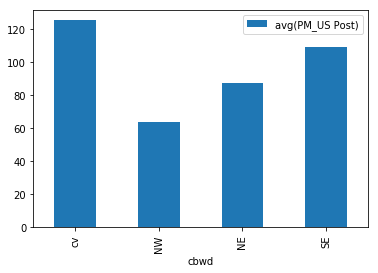

In [3]:
#Explore more in combined wind direction.
dataset2 = spark.read.csv('./Datasets/BeijingPM20100101_20151231.csv',
                          inferSchema = True, header = True)
dataset_cbwd = dataset2.select("PM_US Post","cbwd")
dataset_cbwd = du.set_NA_to_null(dataset_cbwd)
dataset_cbwd = dataset_cbwd.withColumn("PM_US Post",dataset_cbwd["PM_US Post"].cast(IntegerType()))
dataset_cbwd = dataset_cbwd.groupBy('cbwd').mean().na.drop()
pm_mean_df = dataset_cbwd.toPandas()
pm_mean_df = pm_mean_df.set_index('cbwd')
pm_mean_df.plot(kind='bar')
plt.show()

In [4]:
#Reprepare the data by dropping the instances including pm2.5 outliers.
dataset_final = spark.read.csv('./Datasets/cleaned_data.csv',
                          inferSchema = True, header = True)
print("Size of dataset before deleting outliers: ",dataset_final.count())
dataset_final = dataset_final.filter("pm<374")
print("Size of dataset after deleting outliers: ",dataset_final.count())

Size of dataset before deleting outliers:  41732
Size of dataset after deleting outliers:  40953


In [5]:
#Call the function to redo feature selection.
selected_data = dm.feature_selection(dataset_final)
dataset_final = spark.createDataFrame(selected_data)
dataset_final.show(5)

Unimportant features:  ['Is', 'Ir', 'precipitation', 'Iprec', 'rain', 'snow']
+---+---+----+----+------+----+----+----+
| No| pm|DEWP|TEMP|  PRES| Iws|HUMI|cbwd|
+---+---+----+----+------+----+----+----+
| 25|129| -16|-4.0|1020.0|1.79|38.0| 0.0|
| 26|148| -15|-4.0|1020.0|2.68|42.0| 0.0|
| 27|159| -11|-5.0|1021.0|3.57|63.5| 0.0|
| 28|181|  -7|-5.0|1022.0|5.36|85.0| 0.0|
| 29|138|  -7|-5.0|1022.0|6.25|85.0| 0.0|
+---+---+----+----+------+----+----+----+
only showing top 5 rows



In [6]:
#Call the function to re-normalize the predictors and select predictors and the target for data mining.
dataset_final = dm.normalization(dataset_final)
dataset_final = dataset_final.drop("No","DEWP", "TEMP", "PRES","Iws","HUMI","DEWP_vec", 
                             "TEMP_vec", "PRES_vec","Iws_vec","HUMI_vec")
assembler = VectorAssembler(
    inputCols=['DEWP_scaled','TEMP_scaled','PRES_scaled','Iws_scaled','HUMI_scaled','cbwd'],
    outputCol="predictors")
dataset_final = assembler.transform(dataset_final)
dataset_final = dataset_final.select("predictors","pm")
dataset_final.show()

+--------------------+---+
|          predictors| pm|
+--------------------+---+
|[0.35294117647058...|129|
|[0.36764705882352...|148|
|[0.42647058823529...|159|
|[0.48529411764705...|181|
|[0.48529411764705...|138|
|[0.48529411764705...|109|
|[0.48529411764705...|105|
|[0.48529411764705...|124|
|[0.47058823529411...|120|
|[0.48529411764705...|132|
|[0.48529411764705...|140|
|[0.47058823529411...|152|
|[0.47058823529411...|148|
|[0.47058823529411...|164|
|[0.45588235294117...|158|
|[0.45588235294117...|154|
|[0.45588235294117...|159|
|[0.47058823529411...|164|
|[0.47058823529411...|170|
|[0.47058823529411...|149|
+--------------------+---+
only showing top 20 rows



In [7]:
#Re-build and re-choose the parameters for Linear Regression Model.
lr = LinearRegression(featuresCol='predictors', labelCol='pm',
                      fitIntercept=False, standardization=False)

In [8]:
#Re-build and re-choose the parameters for Desicion Tree Regressor Model.
tree = DecisionTreeRegressor(featuresCol="predictors", labelCol='pm',
                             maxDepth=10, minInstancesPerNode=1)

In [9]:
#Split the dataset into two parts, 70% for training and 30% for testing.
data_train,data_test = dataset_final.randomSplit([0.7,0.3])
data_train.describe().show()
data_test.describe().show()

+-------+-----------------+
|summary|               pm|
+-------+-----------------+
|  count|            28644|
|   mean|91.77726574500768|
| stddev|78.24630247745337|
|    min|                0|
|    max|              373|
+-------+-----------------+

+-------+-----------------+
|summary|               pm|
+-------+-----------------+
|  count|            12309|
|   mean|92.37509139653912|
| stddev|78.62816170463498|
|    min|                1|
|    max|              373|
+-------+-----------------+



In [10]:
#Re-conduct the Linear Regression Model.
lr_model = lr.fit(data_train)
lr_test = lr_model.evaluate(data_test)

In [11]:
#Call the function to re-analyze the training data of Linear Regression Model.
dm.analyze_result_lr(lr_model.summary)

Root Mean Squared Error: 	 68.63025716254447
R2 Score: 	 0.6761771609094065
Mean Absolute Error: 	 51.72493563331853
Maximum Error: 	 309.5153981586847
Minimum Error: 	 -159.86123230651975
Mean Error: 	 1.1388532080037095


In [12]:
#Call the function to re-analyze the testing data of Linear Regression Model.
dm.analyze_result_lr(lr_test)

Root Mean Squared Error: 	 69.30841045467224
R2 Score: 	 0.6735547601971704
Mean Absolute Error: 	 52.53581854121398
Maximum Error: 	 300.86339834054485
Minimum Error: 	 -157.68321728378078
Mean Error: 	 1.14996672061622


In [13]:
#Show the new residuals of Linear Regression Model.
lr_test.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -15.45110427546815|
|-19.125332187410457|
| -10.96250155758019|
|-17.266140601439822|
| -16.73041983786674|
| -30.93719303162252|
|-11.956997629150095|
|-19.327429455268835|
| -32.56129727118412|
|-29.342516025636115|
| -21.94529971351934|
| 55.759956177441296|
| -35.80246792745028|
| -34.56502999698099|
|-27.800315426825314|
| -4.484279140669408|
|-14.689412073243481|
| -37.99427889971412|
| -26.58129257229404|
|  -30.6616398902992|
+-------------------+
only showing top 20 rows



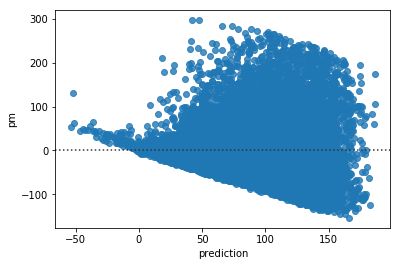

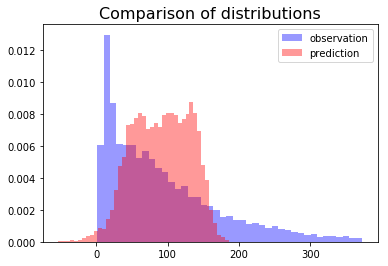

In [14]:
#Call the function to visualize the new residuals of Linear Regression Model.
dm.visualize_residuals(lr_test.predictions)

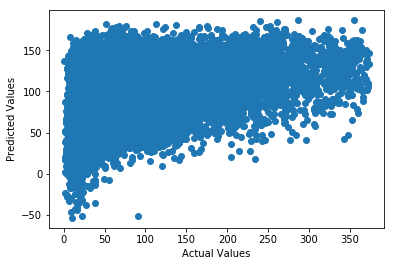

In [15]:
#Call the function to compare and visualize the new predictions and actual records of Linear Regression Model.
dm.prediction_actual_comparison_visulisation(lr_test.predictions)

In [16]:
#Show new coefficients and intercept of Linear Regression Model.
coef = lr_model.coefficients
intercept = lr_model.intercept
print("Coefficients:","\t",coef)
print("Intercept:","\t",intercept)

Coefficients: 	 [-50.592447962048496,44.55048822114061,50.69325330405896,-120.34456596082086,164.8992091786614,-6.10126617155199]
Intercept: 	 0.0


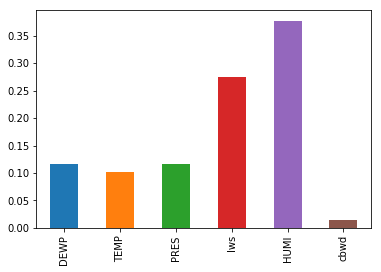

In [17]:
#Call the function to visualize the new feature imporatance of Linear Regression Model.
predictors = dm.get_predictors(spark.createDataFrame(selected_data))
dm.feature_importance(coef,predictors)

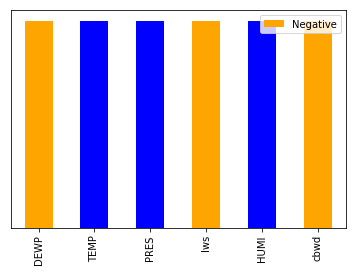

In [18]:
#Call the function to visualize the new coefficients.
dm.coefficients(coef, predictors)

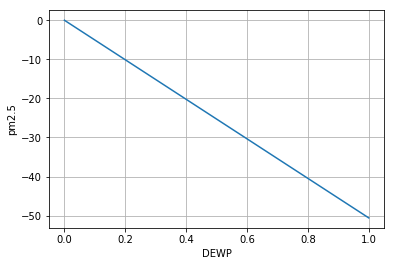

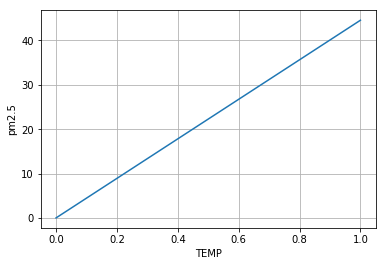

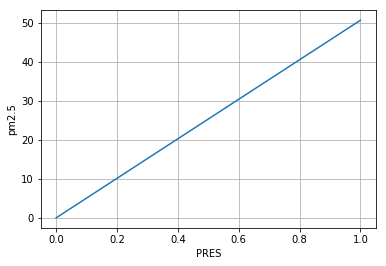

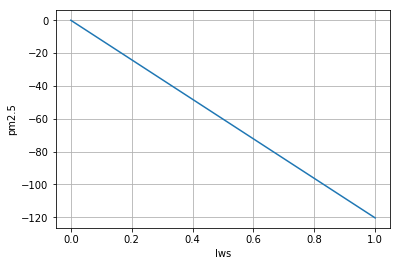

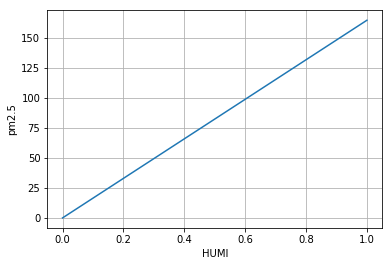

In [19]:
#Call the function to visualize how each attribute affects the target respectively after reiteration.
dm.effect_graph(coef, predictors, intercept)

In [20]:
#Re-conduct the Desicion Tree Regressor Model.
tree_model = tree.fit(data_train)
tree_train = tree_model.transform(data_train)
tree_test = tree_model.transform(data_test)

In [21]:
#Call the function to re-analyze the training data of Desicion Tree Regressor Model.
dm.analyze_result_tree(tree_train)

Root Mean Squared Error: 	 57.23613157000377
R2 Score: 	 0.4649084898825109
Mean Absolute Error: 	 40.64250437782706
Maximum Error: 	 275.20754716981133
Minimum Error: 	 -215.35
Mean Error: 	 2.6858515411731787e-12


In [22]:
#Call the function to re-analyze the testing data of Desicion Tree Regressor Model.
dm.analyze_result_tree(tree_test)

Root Mean Squared Error: 	 63.31627894307097
R2 Score: 	 0.3515002585450827
Mean Absolute Error: 	 45.101610318184825
Maximum Error: 	 307.0
Minimum Error: 	 -280.5
Mean Error: 	 0.5062917447294666


In [23]:
#Show the new residuals of Desicion Tree Regressor Model.
predict_data = tree_test.select("pm","prediction")
residuals = predict_data.withColumn('residuals',
            predict_data['pm']-predict_data['prediction']).select("residuals")
residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -9.754318618042227|
| -7.581395348837209|
| -7.754318618042227|
| -7.581395348837209|
| -5.581395348837209|
|-11.526881720430108|
|-11.870786516853933|
|-1.5813953488372086|
|-13.526881720430108|
|-14.814814814814817|
|-3.5813953488372086|
| -4.754318618042227|
|-12.526881720430108|
|-12.526881720430108|
|            -18.875|
|  -6.76530612244898|
| -5.581395348837209|
|-11.526881720430108|
|-10.581395348837209|
| -7.526881720430108|
+-------------------+
only showing top 20 rows



In [24]:
#Show the new depth of the Desicion Tree.
tree_model.depth

10

In [25]:
#Show the amount of the new nodes of the Desicion Tree.
tree_model.numNodes

1867

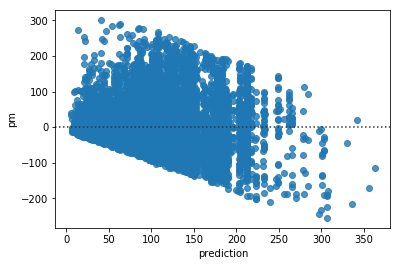

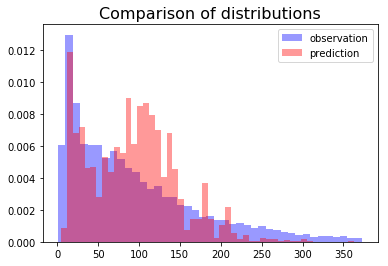

In [26]:
#Call the function to visualize the new residuals of Desicion Tree Regressor Model.
dm.visualize_residuals(tree_test)

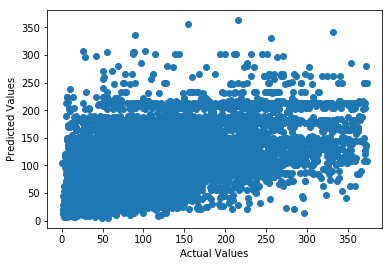

In [27]:
#Call the function to compare and visualize the new predictions and actual records of Desicion Tree Regressor Model.
dm.prediction_actual_comparison_visulisation(tree_test)

In [28]:
#Show the new feature imporatance of Desicion Tree Regressor Model.
importance = tree_model.featureImportances
importance

SparseVector(6, {0: 0.0707, 1: 0.1095, 2: 0.1013, 3: 0.1356, 4: 0.5048, 5: 0.0781})

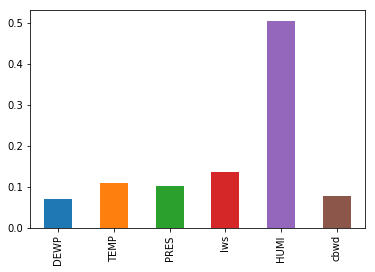

In [29]:
#Call the function to visualize the new feature imporatance of Desicion Tree Regressor Model.
predictors = dm.get_predictors(spark.createDataFrame(selected_data))
dm.feature_importance(importance,predictors)

In [30]:
#Show the new detailed Desision Tree.
tree_detail = tree_model.toDebugString
for i, feat in enumerate(predictors):
    tree_detail = tree_detail.replace('feature ' + str(i), feat)
print(tree_detail)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_40c397b118e81a9b5113) of depth 10 with 1867 nodes
  If (HUMI <= 0.40816326530612246)
   If (cbwd <= 0.0)
    If (HUMI <= 0.2653061224489796)
     If (HUMI <= 0.15306122448979592)
      If (HUMI <= 0.09183673469387756)
       If (DEWP <= 0.35294117647058826)
        If (TEMP <= 0.4918032786885246)
         If (DEWP <= 0.27941176470588236)
          If (PRES <= 0.6727272727272727)
           If (Iws <= 0.004743027042333286)
            Predict: 14.333333333333334
           Else (Iws > 0.004743027042333286)
            Predict: 32.81481481481482
          Else (PRES > 0.6727272727272727)
           If (Iws <= 0.004743027042333286)
            Predict: 32.75
           Else (Iws > 0.004743027042333286)
            Predict: 52.5
         Else (DEWP > 0.27941176470588236)
          If (Iws <= 0.0023715135211666433)
           If (PRES <= 0.509090909090909)
            Predict: 127.0
           Else (PRES > 0.509090909090909)
           